In [1]:
import torch
from torch import nn
from torch.nn import Module
import torch.nn.functional as F

In [2]:
import torchvision
from torchvision import datasets
from torchvision import transforms
from torch.autograd import Variable

In [3]:
import brevitas.nn as qnn
from brevitas.quant import Int8Bias as BiasQuant
from brevitas.export import FINNManager
from brevitas.export import StdQOpONNXManager

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import time

In [5]:
start_time = time.time()

In [6]:
n_epochs = 3
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [7]:
data_train = torchvision.datasets.MNIST('./data/', 
                                        train=True, download=True,
                                        transform=torchvision.transforms.Compose
                                        ([
                                            torchvision.transforms.ToTensor(),
                                            torchvision.transforms.Normalize((0.1307,), (0.3081,))
                                        ]))
data_test = torchvision.datasets.MNIST('./data/', 
                                       train=False, download=True,
                                       transform=torchvision.transforms.Compose
                                       ([
                                            torchvision.transforms.ToTensor(),
                                            torchvision.transforms.Normalize((0.1307,), (0.3081,))
                                       ]))

In [8]:
data_loader_train = torch.utils.data.DataLoader(dataset=data_train,
                                                batch_size=batch_size_train, 
                                                shuffle=True)

In [9]:
data_loader_test = torch.utils.data.DataLoader(dataset=data_test,
                                               batch_size=batch_size_test, 
                                               shuffle=True)

In [10]:
examples = enumerate(data_loader_test)
batch_idx, (example_data, example_targets) = next(examples)
example_data.shape

torch.Size([1000, 1, 28, 28])

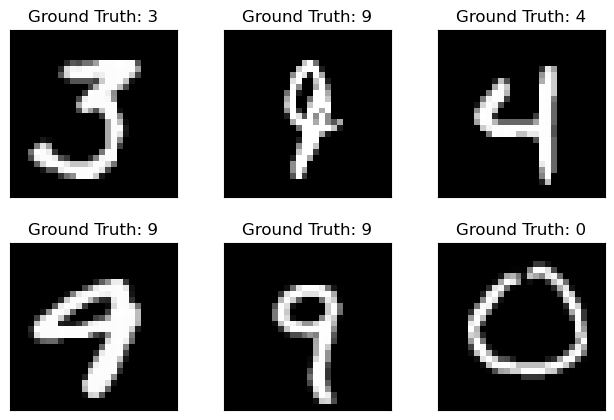

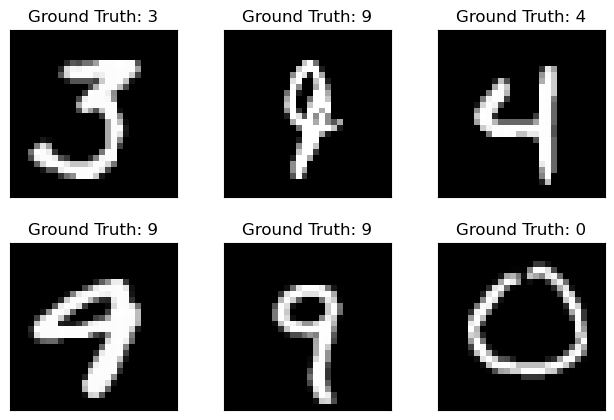

In [11]:
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

In [12]:
class LowPrecisionMLP(Module):
    def __init__(self):
        super(LowPrecisionMLP, self).__init__()
        self.quant_inp = qnn.QuantIdentity(
            bit_width=4, return_quant_tensor=True)
        self.fc1   = qnn.QuantLinear(
            1*28*28, 32, bias=True, weight_bit_width=8, bias_quant=BiasQuant, return_quant_tensor=True)
        self.relu1 = qnn.QuantReLU(
            bit_width=4, return_quant_tensor=True)
        self.fc2   = qnn.QuantLinear(
            32, 32, bias=True, weight_bit_width=8, bias_quant=BiasQuant, return_quant_tensor=True)
        self.relu2 = qnn.QuantReLU(
            bit_width=4, return_quant_tensor=True)
        self.fc3   = qnn.QuantLinear(
            32, 32, bias=True, weight_bit_width=8, bias_quant=BiasQuant, return_quant_tensor=True)
        self.relu3 = qnn.QuantReLU(
            bit_width=4, return_quant_tensor=True)
        self.fc4   = qnn.QuantLinear(
            32, 10, bias=False, weight_bit_width=8)

    def forward(self, x):
        out = self.quant_inp(x)
        out = out.reshape(out.shape[0], -1)
        out = self.relu1(self.fc1(out))
        out = self.relu2(self.fc2(out))
        out = self.relu3(self.fc3(out))
        out = self.fc4(out)
        return out

In [13]:
low_precision_mlp = LowPrecisionMLP()

In [14]:
cost=torch.nn.CrossEntropyLoss()

In [15]:
optimizer = torch.optim.Adam(low_precision_mlp.parameters())

In [16]:
# 卷积神经网络模型进行模型训练和参数优化的代码
n_epochs = 5
 
for epoch in range(n_epochs):
    running_loss = 0.0
    running_correct = 0
    print("Epoch  {}/{}".format(epoch, n_epochs))
    print("-"*10)
    for data in data_loader_train:
        X_train , y_train = data
        # 有GPU加下面这行，没有不用加
        # X_train, y_train = X_train.cuda(), y_train.cuda()
        X_train , y_train = Variable(X_train),Variable(y_train)
        # print(y_train)
        outputs = low_precision_mlp(X_train)
        # print(outputs)
        _,pred = torch.max(outputs.data,1)
        optimizer.zero_grad()
        loss = cost(outputs,y_train)
 
        loss.backward()
        optimizer.step()
        # running_loss += loss.data[0]
        running_loss += loss.item()
        running_correct += torch.sum(pred == y_train.data)
        # print("ok")
        # print("**************%s"%running_corrrect)
 
    print("train ok ")
    testing_correct = 0
    for data in data_loader_test:
        X_test,y_test = data
        # 有GPU加下面这行，没有不用加
        # X_test, y_test = X_test.cuda(), y_test.cuda()
        X_test,y_test = Variable(X_test),Variable(y_test)
        outputs = low_precision_mlp(X_test)
        _, pred = torch.max(outputs,1)
        testing_correct += torch.sum(pred == y_test.data)
        # print(testing_correct)
 
    print( "Loss is :{:.4f},Train Accuracy is:{:.4f}%,Test Accuracy is:{:.4f}".format(
                 running_loss / len(data_train),100 * running_correct / len(data_train),
                 100 * testing_correct / len(data_test)))

Epoch  0/5
----------
train ok 
Loss is :0.0064,Train Accuracy is:87.5450%,Test Accuracy is:92.9600
Epoch  1/5
----------
train ok 
Loss is :0.0030,Train Accuracy is:94.2733%,Test Accuracy is:94.7700
Epoch  2/5
----------
train ok 
Loss is :0.0024,Train Accuracy is:95.3467%,Test Accuracy is:94.5500
Epoch  3/5
----------
train ok 
Loss is :0.0020,Train Accuracy is:96.0483%,Test Accuracy is:95.4200
Epoch  4/5
----------
train ok 
Loss is :0.0017,Train Accuracy is:96.5500%,Test Accuracy is:95.5500


In [17]:
stop_time = time.time()
print("time is %s" %(stop_time-start_time))

time is 102.65259170532227


In [18]:
FINNManager.export(low_precision_mlp, input_shape=(1, 28, 28), export_path='finn_xxsfc_w8a4.onnx')

================ Diagnostic Run torch.onnx.export version 2.0.0 ================
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



ir_version: 7
producer_name: "pytorch"
producer_version: "2.0.0"
graph {
  node {
    input: "inp.1"
    input: "/quant_inp/export_handler/Constant_output_0"
    output: "/quant_inp/export_handler/MultiThreshold_output_0"
    name: "/quant_inp/export_handler/MultiThreshold"
    op_type: "MultiThreshold"
    attribute {
      name: "out_dtype"
      s: "INT4"
      type: STRING
    }
    domain: "finn.custom_op.general"
  }
  node {
    input: "/quant_inp/export_handler/MultiThreshold_output_0"
    input: "/quant_inp/export_handler/Constant_1_output_0"
    output: "/quant_inp/export_handler/Add_output_0"
    name: "/quant_inp/export_handler/Add"
    op_type: "Add"
    domain: ""
  }
  node {
    input: "/quant_inp/export_handler/Add_output_0"
    input: "/quant_inp/export_handler/Constant_2_output_0"
    output: "/quant_inp/export_handler/Mul_output_0"
    name: "/quant_inp/export_handler/Mul"
    op_type: "Mul"
  }
  node {
    input: "/quant_inp/export_handler/Mul_output_0"
    output